In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sms
import statsmodels.api as sm
%matplotlib inline
import seaborn as sns
from pandas.plotting import lag_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")


In [47]:
# #Mounting GoogleDrive
# from google.colab import drive
# drive.mount('/content/drive/')

In [48]:
#Reading the file
# df = pd.read_csv("/content/drive/MyDrive/Datasets/Airlines+Data.xlsx")
df = pd.read_excel('Airlines+Data.xlsx',index_col=0, parse_dates=['Month'])

In [49]:
df.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


In [50]:
df.isna().sum()

Passengers    0
dtype: int64

In [51]:
df.shape

(96, 1)

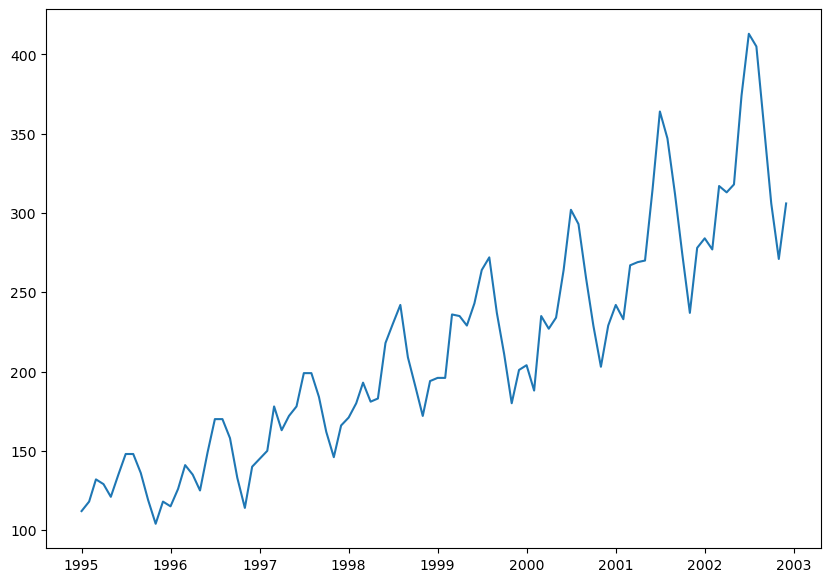

In [52]:
plt.figure(figsize=(10,7))
plt.plot(df)

array([[<Axes: title={'center': 'Passengers'}>]], dtype=object)

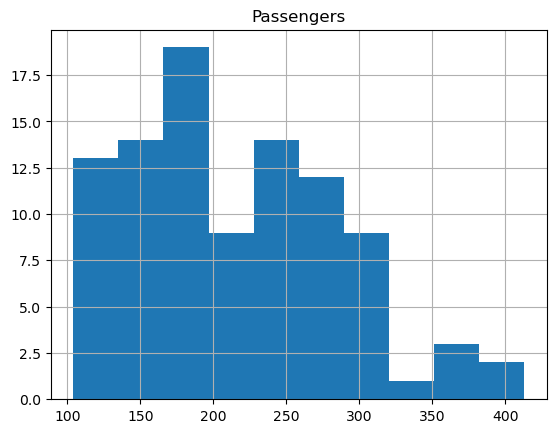

In [53]:
df.hist()

<Figure size 2000x500 with 0 Axes>

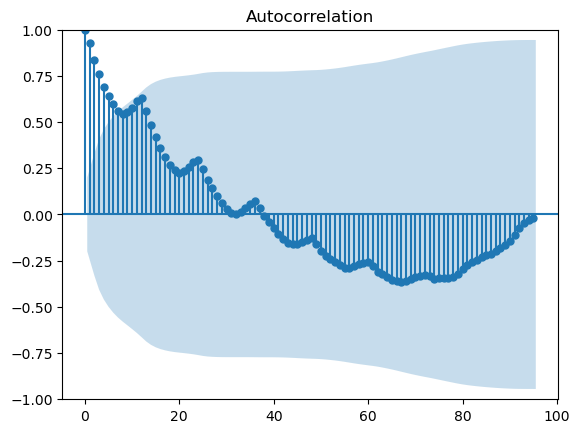

In [54]:
#Autocorrelation Plot
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(20,5))
plot_acf(df,lags=95)
plt.show()

<Figure size 2000x500 with 0 Axes>

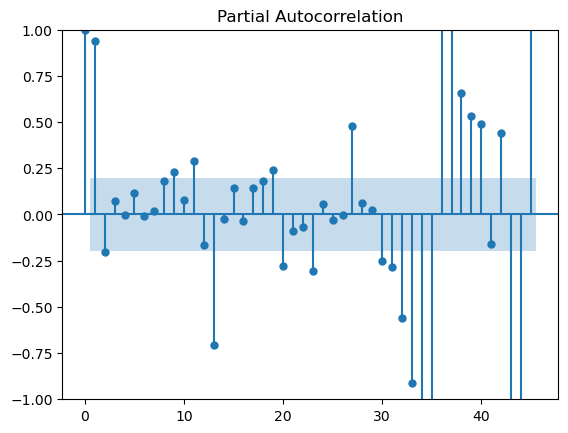

In [55]:
#PACF
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(20,5))
plot_pacf(df.Passengers,lags=45)
plt.show()

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

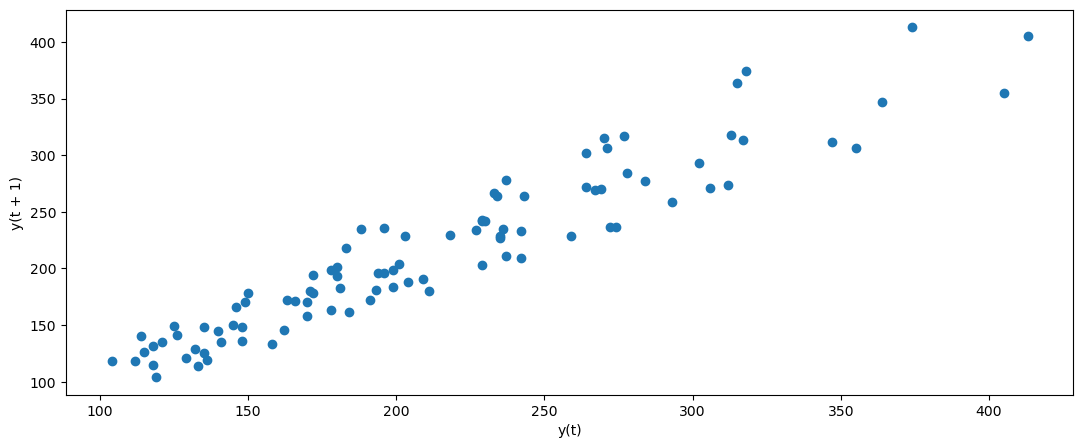

In [56]:
#Lag Plot
plt.figure(figsize=(13,5))
pd.plotting.lag_plot(df)

In [57]:
#Upsampling
upsampled=df.resample('D').mean()
upsampled.head()

,Passengers
Month,
1995-01-01,112.0
1995-01-02,NaN
1995-01-03,NaN
1995-01-04,NaN
1995-01-05,NaN


In [58]:
interpolated=upsampled.interpolate(method='linear')
interpolated.head(10)

,Passengers
Month,
1995-01-01,112.000000
1995-01-02,112.193548
1995-01-03,112.387097
1995-01-04,112.580645
1995-01-05,112.774194
1995-01-06,112.967742
1995-01-07,113.161290
1995-01-08,113.354839
1995-01-09,113.548387


<Axes: xlabel='Month'>

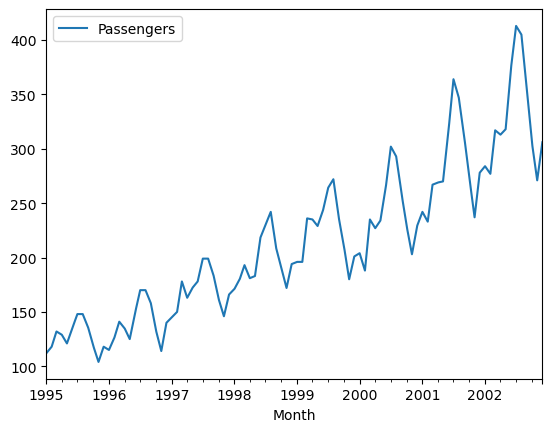

In [59]:
interpolated.plot()

In [60]:
#Downsampling

downsampled=df.resample('Q').mean()
downsampled.head()

,Passengers
Month,
1995-03-31,120.666667
1995-06-30,128.333333
1995-09-30,144.000000
1995-12-31,113.666667
1996-03-31,127.333333


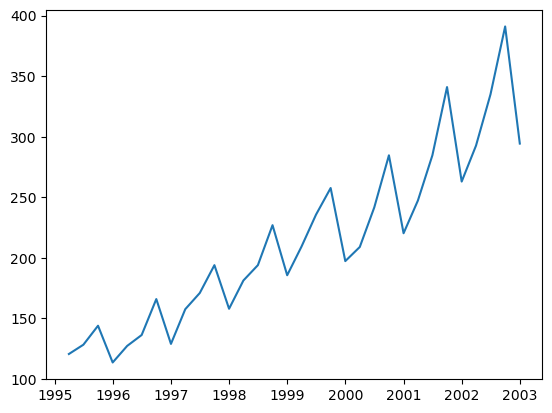

In [61]:
plt.plot(downsampled)

In [62]:
df.columns = df.columns.str.strip()
df = df.reset_index()


In [63]:
df["month"]=df['Month'].dt.strftime("%b")
df["year"]=df['Month'].dt.strftime("%Y")
df['log_passengers']=np.log(df['Passengers'])
df['t']=np.arange(1,97)
df['t_square']=np.square(df['t'])
df1=pd.get_dummies(df['month'])
df=pd.concat([df,df1],axis=1)
df.head()

,Month,Passengers,month,year,log_passengers,t,t_square,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1995-01-01,112,Jan,1995,4.718499,1,1,0,0,0,0,1,0,0,0,0,0,0,0
1,1995-02-01,118,Feb,1995,4.770685,2,4,0,0,0,1,0,0,0,0,0,0,0,0
2,1995-03-01,132,Mar,1995,4.882802,3,9,0,0,0,0,0,0,0,1,0,0,0,0
3,1995-04-01,129,Apr,1995,4.859812,4,16,1,0,0,0,0,0,0,0,0,0,0,0
4,1995-05-01,121,May,1995,4.795791,5,25,0,0,0,0,0,0,0,0,1,0,0,0


<Axes: xlabel='month', ylabel='year'>

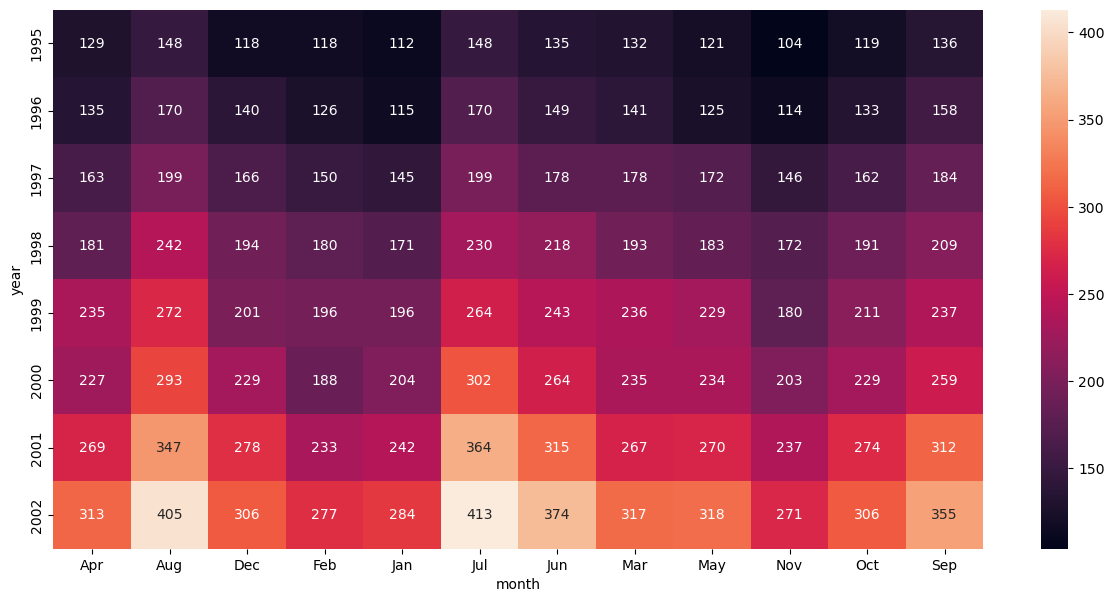

In [64]:
#Heatmap
hm=pd.pivot_table(data=df,values="Passengers",columns="month",index='year')
plt.figure(figsize=(15,7))
sns.heatmap(hm,annot=True,fmt='g')

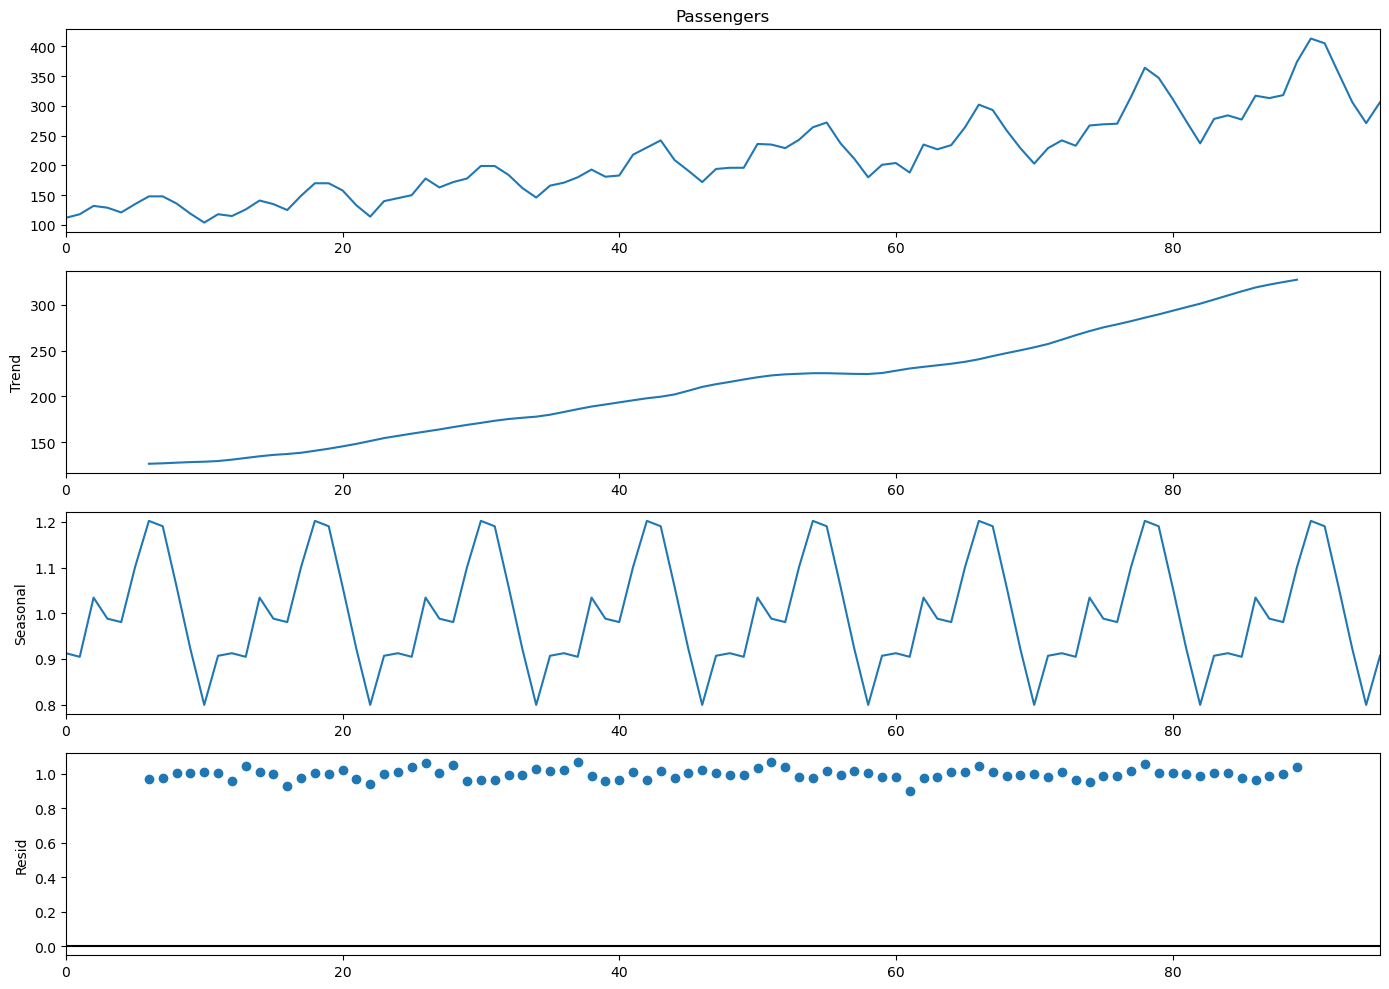

In [65]:
#Multiplicative Seasonality Decomposition

decompose_ts_add = seasonal_decompose(df.Passengers,period=12, model='multiplicative')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

In [66]:
#Data Spliting
Train = df.head(84)
Test = df.tail(12)

In [67]:
#Linear Model
import statsmodels.formula.api as smf

linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_linear))**2))
rmse_linear

53.199236534802715

In [68]:
#Exponential
Exp = smf.ols('log_passengers~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

46.0573611031562

In [69]:
#Quadratic
Quad = smf.ols('Passengers~t+t_square',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_square"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_Quad))**2))
rmse_Quad

48.051888979330975

In [70]:
#Additive seasonality
add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea

132.81978481421817

In [71]:
#Additive Seasonality Quadratic
add_sea_Quad = smf.ols('Passengers~t+t_square+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_square']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

26.360817612086453

In [72]:
##Multiplicative Seasonality
Mul_sea = smf.ols('log_passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

140.06320204708646

In [73]:
#Multiplicative Additive Seasonality
Mul_Add_sea = smf.ols('log_passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea

10.519172544323721

In [74]:
#Multiplicative Seasonality Quadratic
mult_sea_Quad = smf.ols('log_passengers~t+t_square+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_mult_sea_quad = pd.Series(mult_sea_Quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_square']]))
rmse_mult_sea_quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_mult_sea_quad))**2))
rmse_mult_sea_quad

325.7312105213405

In [75]:
data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
6,rmse_Mult_add_sea,10.519173
4,rmse_add_sea_quad,26.360818
1,rmse_Exp,46.057361
2,rmse_Quad,48.051889
0,rmse_linear,53.199237
3,rmse_add_sea,132.819785
5,rmse_Mult_sea,140.063202


In [76]:
""" Dickey Fuller Test for testing the data is stationary or not """

def adf_test(series):
    result = adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    if result[1] <= 0.05:
       print("Strong evidence against the null hypothesis,reject the null hypothesis.Data has no unit root and is stationary")
    else:
       print("Weak evidence against null hypothesis,time series has unit root , indicating it is non -statinary")


adf_test(df['Passengers'])



ADF Statistics: 1.3402479596466974
p-value: 0.9968250481137263
Weak evidence against null hypothesis,time series has unit root , indicating it is non -statinary


In [77]:

""" using techniques Differencing   """

df['Passengers First Difference']=df['Passengers']-df['Passengers'].shift(1)
df.head()

adf_test(df['Passengers First Difference'].dropna())
# data is still not stationary.


ADF Statistics: -2.15000173592066
p-value: 0.22488942647512306
Weak evidence against null hypothesis,time series has unit root , indicating it is non -statinary


In [78]:

""" using second differencing technique """

df['Passengers Second Difference'] = df['Passengers First Difference']-df['Passengers First Difference'].shift(1)

adf_test(df['Passengers Second Difference'].dropna())



ADF Statistics: -11.547980944840836
p-value: 3.50318023632083e-21
Strong evidence against the null hypothesis,reject the null hypothesis.Data has no unit root and is stationary


In [79]:

""" we are checking for over a year now  ( we are looking for seasonal differences now and sometimes ARIMA doesnot work well for seasonal data but SARIMAX Does )"""


' we are checking for over a year now  ( we are looking for seasonal differences now and sometimes ARIMA doesnot work well for seasonal data but SARIMAX Does )'

In [80]:
df['Passengers 12 Difference']=df['Passengers']-df['Passengers'].shift(12)
adf_test(df['Passengers 12 Difference'].dropna())



ADF Statistics: -2.6900043838623167
p-value: 0.07578397625851754
Weak evidence against null hypothesis,time series has unit root , indicating it is non -statinary


<Axes: >

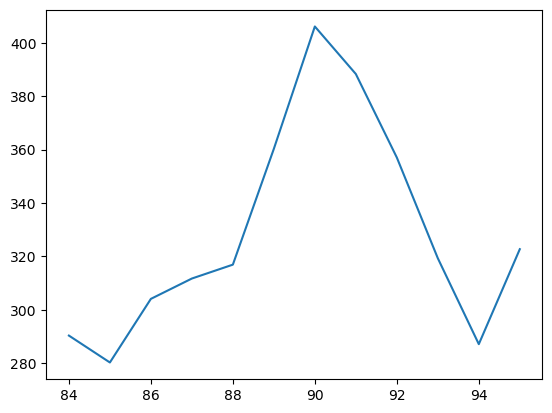

In [81]:
"""   Fit the ARIMA model  """
model = ARIMA(Train['Passengers'], order=(11, 2, 2))
model_fit = model.fit()

# Make predictions on the testing set
predictions = model_fit.forecast(steps=len(Test))

predictions.plot()


In [82]:
#predictions

# Check the shape of the input arrays
if Test['Passengers'].shape[0] > 1 and predictions.shape[0] > 1:
    # Calculate the mean squared error
    mse = mean_squared_error(Test['Passengers'], predictions)

    # Calculate the root mean squared error
    rmse = np.sqrt(mse)
    print('RMSE:', rmse)
else:
    print('Error: Input arrays have only one element')



RMSE: 11.00871355334346


<Axes: >

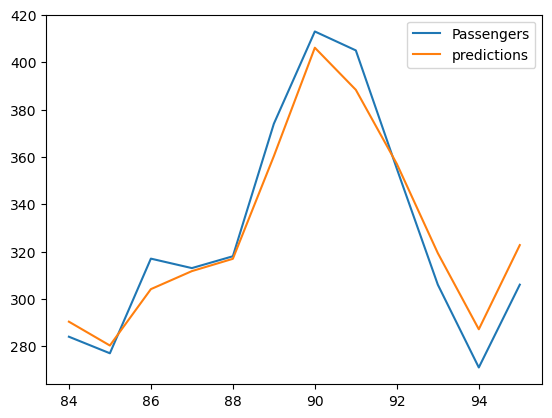

In [83]:

model_fit.summary()
Test['predictions'] = predictions

Test[['Passengers','predictions']].plot()



In [84]:
"""  SARIMAX   """
# Fit SARIMA model
model_SARIMA = SARIMAX(Train['Passengers'], order=(11, 2, 2), seasonal_order=(0, 0, 0, 12))
model_SARIMA_fit = model_SARIMA.fit()

# Make predictions on the testing set
predictions_SARIMA = model_SARIMA_fit.forecast(steps=len(Test))

# Check the shape of the input arrays
if Test['Passengers'].shape[0] > 1 and predictions_SARIMA.shape[0] > 1:
    # Calculate the mean squared error
    mse = mean_squared_error(Test['Passengers'], predictions_SARIMA)

In [85]:
# Calculate the root mean squared error
rmse = np.sqrt(mse)
print('RMSE:', rmse)


RMSE: 11.00871355334346


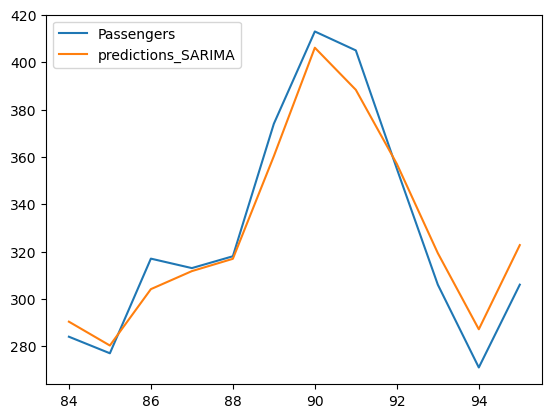

In [86]:
# Display model summary
model_SARIMA_fit.summary()

# Add predictions to test_data
Test['predictions_SARIMA'] = predictions_SARIMA
# Plot actual vs predicted values
Test[['Passengers', 'predictions_SARIMA']].plot()
plt.show()



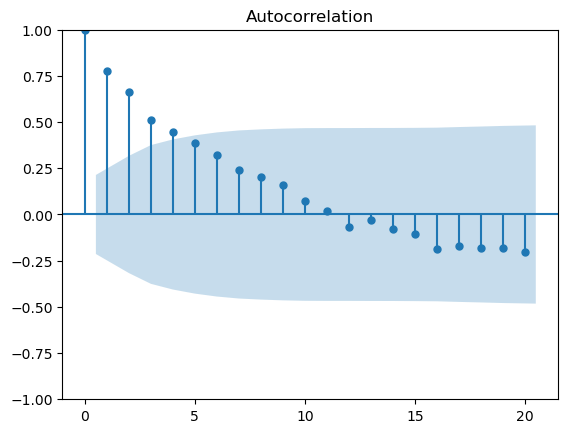

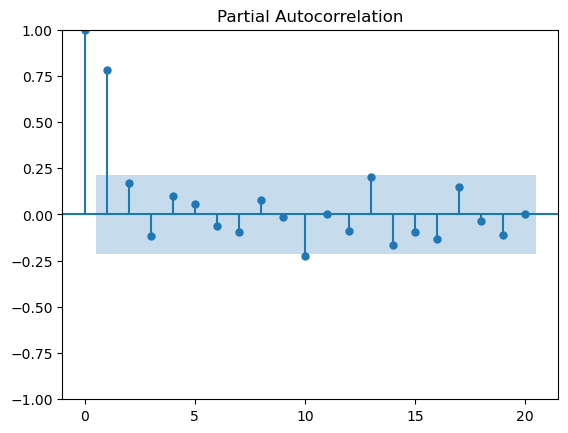

In [87]:
acf12 = plot_acf(df['Passengers 12 Difference'].dropna())
pacf12 = plot_pacf(df['Passengers 12 Difference'].dropna())


In [88]:
""" considering the data to be seasonal checking with the results for arima and sarimax models """

from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Fit ARIMA model
model_ARIMA = ARIMA(Train['Passengers'], order=(3, 0, 5))
model_ARIMA_fit = model_ARIMA.fit()
predictions_ARIMA = model_ARIMA_fit.forecast(steps=len(Test))

# Fit SARIMA model
model_SARIMA = SARIMAX(Train['Passengers'], order=(3, 0, 5), seasonal_order=(0, 1, 0, 12))
model_SARIMA_fit = model_SARIMA.fit()
predictions_SARIMA = model_SARIMA_fit.forecast(steps=len(Test))

# Calculate RMSE for ARIMA
mse_ARIMA = mean_squared_error(Test['Passengers'], predictions_ARIMA)
rmse_ARIMA = np.sqrt(mse_ARIMA)
print('RMSE (ARIMA):', rmse_ARIMA)

# Calculate RMSE for SARIMA
mse_SARIMA = mean_squared_error(Test['Passengers'], predictions_SARIMA)
rmse_SARIMA = np.sqrt(mse_SARIMA)
print('RMSE (SARIMA):', rmse_SARIMA)


RMSE (ARIMA): 66.65446795435881
RMSE (SARIMA): 9.43362222895097


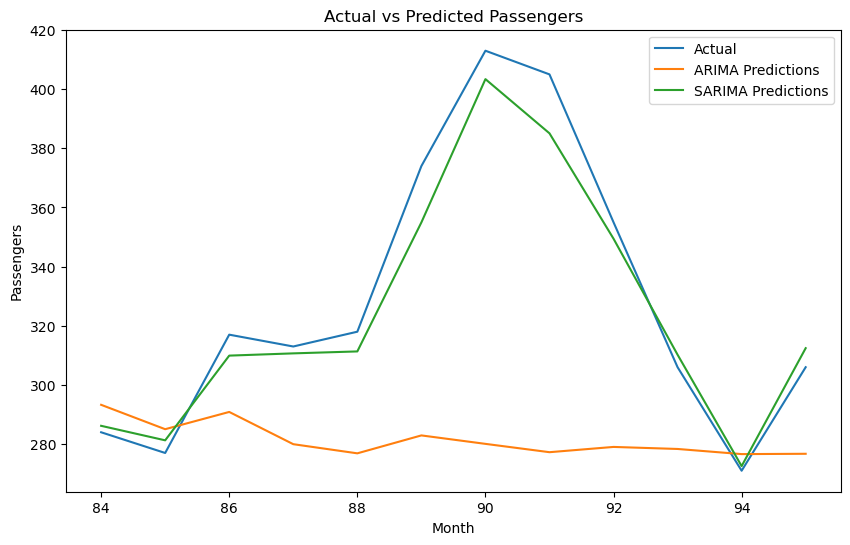

In [89]:

# Plot actual vs predicted values for both models
plt.figure(figsize=(10, 6))
plt.plot(Test['Passengers'], label='Actual')
plt.plot(predictions_ARIMA, label='ARIMA Predictions')
plt.plot(predictions_SARIMA, label='SARIMA Predictions')
plt.legend()
plt.title('Actual vs Predicted Passengers')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.show()


In [90]:
#Inference:
#SARIMA gives better results